In [172]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [173]:
from b2heavy.FnalHISQMetadata import params as mData

In [174]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, ratio_correction_factor
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [175]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_DIR = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/CORRELATORS'

# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'


BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [181]:
ENSEMBLE = 'Coarse-Phys'
RATIO    = 'ZRA1'
SMSLIST  = ['1S','RW']
# SMSLIST  = ['1S']
# MOMLIST  = ['100','200','300','400']
MOMLIST  = ['000']

In [182]:
if RATIO in ['RMINUS','RPLUS','QPLUS','XF']:
    meson = 'D'
else:
    meson = 'Dst'

In [183]:
TMIN    = 1
NSTATES = 1

In [184]:
JK = False

# ---------- chi^2_exp analysis -------------
# chi2_exp = 22.00000000000377 +/- 6.633249580712471 
# p-value [eval] = 0.0
# p-value [MC]   = 0.0
# ---------- 1+1 fit in (1, 11) for mes: ZRA1 of ens: Coarse-Phys for mom: 000 --------------
Least Square Fit:
  chi2/dof [dof] = 8.4 [22]    Q = 7e-28    logGBF = -35.615

Parameters:
        ratio 0     -4.77 (10)      [ -4.79 (10) ]  
         A_1S 0    -0.416 (16)      [    0 ± 1.0 ]  
         B_1S 0   -0.4670 (90)      [    0 ± 1.0 ]  
         A_RW 0      0.33 (19)      [    0 ± 1.0 ]  
         B_RW 0      0.56 (19)      [    0 ± 1.0 ]  
       dE_src 0     -4.35 (25)      [  1.08 (50) ]  *****

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 30/0.0)
  fitter = scipy_least_squares    method = trf

# red chi2       = 67.12
# aug chi2       = 185.70
# chi2_exp       = 22.00
# chi2/chi_exp   = 8.44
# p-value (exp)  = 0.00
# p-value (std)  = 0.00


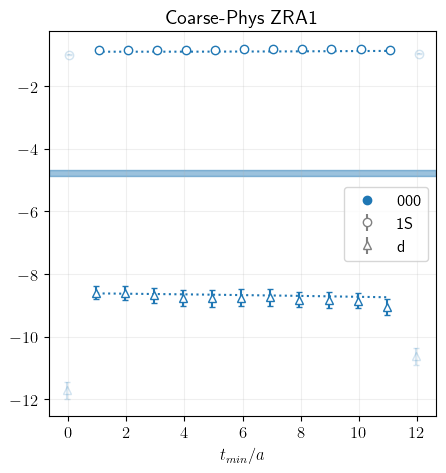

In [185]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,1,figsize=(5,5))

fits = []
f0s = []
for i,mom in enumerate(MOMLIST):
    requisites = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = JK
    )

    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)
    robj = RatioFitter(
        io,
        jkBin     = BINSIZE[ENSEMBLE],
        smearing  = SMSLIST,
        # readfrom  = DATA_2PT,
        **requisites
    )

    trange = (TMIN, robj.Ta-TMIN)

    cov_specs = dict(
        diag   = False,
        block  = False,
        scale  = True,
        shrink = True,
        cutsvd = 1E-12
    )

    dE_src = phys_energy_priors(ENSEMBLE,meson,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)

    fit = robj.fit(
        Nstates = NSTATES,
        trange  = trange,
        priors  = pr,
        verbose = False,
        **cov_specs
    )

    res = robj.fit_result(
        Nexc   = NSTATES,
        trange = trange,
        priors = pr 
    )

    fits.append({
        'ensemble': ENSEMBLE,
        'ratio'   : RATIO,
        'momentum': mom,
        'f0'      : fit.p['ratio'][0],
        'chiexp'  : res['chiexp'],
        'pstd'    : res['pstd']
    })


    alpha = 0.2 if mom=='400' else 1.
    robj.plot_fit(ax,NSTATES,trange,color=f'C{i}',color_res=f'C{i}',alpha=alpha,minus=False)

    ax.scatter([],[], marker='o', color=f'C{i}', label=mom)


    f0s.append(fit.p['ratio'][0])

ax.errorbar([],[],[],fmt='o', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='1S')
ax.errorbar([],[],[],fmt='^', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='d')

# ax.set_xlim(-0.5,13)
# ax.set_ylim(ymax=0.35,ymin=0.)
ax.grid(alpha=0.2)
ax.legend()

ax.set_xlabel(r'$t_{min}/a$')

ax.set_title(f'{ENSEMBLE} {RATIO}')

# ax.set_ylabel(r'$Q_+$')


plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_{RATIO}_multimom_new.pdf')

In [ ]:
pd.DataFrame(fits).set_index(['ensemble','ratio','momentum'])

f0  chiexp      pstd
ensemble    ratio momentum                              
Coarse-Phys R1    100       1.0326(62)    22.0  0.032720
                  200       1.0795(81)    22.0  0.042539
                  300        1.173(17)    22.0  0.030869
                  400        1.195(20)    22.0  0.023423